# Spit for Science—1df GWAS Results Processing
**Author:** Jesse Marks <br>
**Date:** October 12, 2018 <br>
**GitHub Issue:** [#55](https://github.com/RTIInternational/bioinformatics/issues/55) <br>
**Data Retrieval:** `s3://rti-uploads/faliev` <br>
**Data Upload:** `s3://rti-nd/sfs/1df/results/`


This notebook documents the steps and procedures taken to process the GWAS results from the [Spit for Science (SFS)](https://spit4science.vcu.edu/) cohort. This cohort will be included in the updated wave 3 FTND meta-analysis (nicotine dependence). The SFS cohort includes GWAS results from 5 ancestry groups, namely:

* AFR, African
* AMR, Ad Mixed American
* EAS, East Asian
* EUR, European
* SAS, South Asian

We will first convert the GWAS results into a format consistent with the cohorts in the FTND meta-analysis; the other cohorts have all been converted to ProbAbel format. We will then apply a script which creates Manhattan and QQ plots for each ancestry group. We will be able to examine the lambda value from the QQ-plot and determine if genomic control should be applied to any of the ancestry groups. This is the extent of what this notebook will document. 

Finally, the data will be included in three meta-analyses. 
1. EUR-specific
2. AFR-specific
3. cross-ancestry (include all 5 ancestry groups)

## Download Data From S3

In [ ]:
## EC2 console ##
data_dir=/home/ec2-user/jmarks/nicotine/spit_science/
mkdir -p ${data_dir}/{original_results,processed_results}
mkdir -p ${data_dir}/processed_results/{aa,amr,ea,eas,sas}

aws s3 sync s3://rti-uploads/faliev/ ${data_dir}/original_results

# unzip
gzip -d ${data_dir}/original_results* &

## Split up by chromosome
These GWAS results are all combined in one file. We will split them apart by chromosome first.

### EUR
Original results file header:
```
 CHR    SNP         BP   A1       TEST    NMISS       BETA       SE      L95      U95         STAT            P
 ```

In [ ]:
import gzip,sys
BASE_DIR = "/home/ec2-user/jmarks/nicotine/spit_science/"
AFR = "AFR_final_ftnd.summary.gz"
AMR = "AMR_final_ftnd.summary.gz"
EAS = "EAS_final_ftnd.summary.gz"
EUR = "EUR_final_ftnd.summary.gz"
SAS = "SAS_final_ftnd.summary.gz"

data_list = [AFR,AMR,EAS,EUR,SAS]
ancestry_list = ['aa','amr','eas','ea','sas']
#data_list = [AFR]
#ancestry_list = ['aa']

for data, ancestry in zip(data_list, ancestry_list):
    inF = gzip.open(BASE_DIR + "original_results/" + data)
    # each time this is called, the next line will be returned.
    header = inF.readline().split()
    # split returns a list of words (headers)
    chrIndex = header.index("CHR") # returns 0 because CHROM is first header
    snp_index = header.index("SNP") # of form rsID:position:A1:A2
    pos_index = header.index("BP")
    a2_index = header.index("A1") + 1
    header.insert(a2_index, "A2")
    header.insert(0, "Marker")
    lastChr = ''
    line = inF.readline()
    processed_list = []
    while(line): # while we are not at the end of the file
        split_line = line.split()
        current_chr = split_line[chrIndex]
        a2 = split_line[snp_index].split(":")[-1] # get the A2 allele
        split_line.insert(a2_index, a2)

        # if the new line is not the same chromosome as the last one processed enter loop
        # note it will enter this loop right from the gitgo because lastChr= '' by default
        if(current_chr != lastChr):
            proc_message = "Processing {}: Chr{}".format(ancestry, current_chr)
            print(proc_message)
            # keep track of which chromosomes have been processed
            processed_list.append(current_chr)
            times_processed = processed_list.count(current_chr)
            lastChr = current_chr # new last chromosome now

            # construct outfile name
            fname = 'sfs.' + ancestry + '.1000G.chr' + split_line[chrIndex] + '.' + 'CAT_FTND~1df_add.out.txt'
            out_dir = "processed_results/{}/processing/chr{}/".format(ancestry, split_line[chrIndex])
            outF = file(BASE_DIR + out_dir + fname, 'a')

            # if the current chromosome has not been seen before then write a header to a new file
            if times_processed == 1:
                # write to a new file based on the new chr we are processing
                # also add the column Marker to the column header
                outF.write("\t".join(header) + "\n")
        # creating the Markername = CHR:POSITION in first field
        out_line = "{}:{}\t{}\n".format(split_line[chrIndex], split_line[pos_index], "\t".join(split_line))
        outF.write(out_line)
        #outF.write(split_line[chrIndex] + ":" + split_line[pos_index] + "\t" + "\t".join(split_line) + "\n")
        line = inF.readline() # read the next line


## Then perform ID conversion, filtering, and plotting using script here

In [ ]:
### Bash ###

ancestry_list = 'amr aa ea eas sas'
base_dir=/shared/jmarks/processed_results

for ethnicity in ${ancestry_list}; do
    for (( chr=1; chr<23; chr++ )); do
        mkdir -p ${base_dir}/$ethnicity/processing/chr$chr done
    done
    mkdir ${base_dir}/$ethnicity/final
done

### Convert ID to phase 3 ID ###
for ethnicity in ${ancestry_list}; do
    for (( chr=1; chr<23; chr++ )); do
        out_file=${base_dir}/$ethnicity/processing/chr$chr/sfs.$ethnicity.1000G.chr$chr.CAT_FTND~1df.phase3ID_add.out.txt
        in_file=${base_dir}/$ethnicity/processing/chr$chr/sfs.$ethnicity.1000G.chr$chr.CAT_FTND~1df_add.out.txt
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name SFS_${ethnicity}_chr${chr} \
            --script_prefix ${out_file} \
            --mem 15 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in ${in_file} \
                --file_out ${out_file} \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 1 \
                --file_in_id_col 0 \
                --file_in_chr_col 1 \
                --file_in_pos_col 3 \
                --file_in_a1_col 4 \
                --file_in_a2_col 5 \
                --chr $chr
    done
done

# Check for completion
for ethnicity in ea; do
    if [ $ethnicity == "aa" ]; then
        group=afr
    elif [ $ethnicity == "amr" ]; then
        group=amr
    elif [ $ethnicity == "eas" ]; then
        group=eas
    elif [ $ethnicity == "sas" ]; then
        group=sas
    else
        group=eur
    fi
    for (( chr=1; chr<23; chr++ ))
    do
        file=/shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr$chr/minnesota_twins.$ethnicity.1000G.chr$chr.CAT_FTND~1df.phase3ID_add.out.txt.qsub.log
        if [ -f $file ]
        then
          logLineCount=$(wc -l $file | perl -lane 'print $F[0];')
          if [ $logLineCount -ne 4 ]
          then
            echo $file line count: $logLineCount
          else
            tail -n 1 $file |
              perl -ne 'chomp; if (!/^Done/) { print "'$file'\n".$_."\n"; }'
          fi
        else
          echo $file missing
        fi
    done
done



### START Filter ###
# create 1000G_p3 MAF filtered files
thouDir=/shared/data/ref_panels/1000G/2014.10
for chr in {1..22};do
    awk ' { if ( $9>=0.01 ) { print $1 } }' <(zcat $thouDir/1000GP_Phase3_chr$chr.legend.gz) >\
        $thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_eur
done &



thouDir=/shared/data/ref_panels/1000G/2014.10
# MAF > 0.01 in AFR (AA) or EUR (EA)
for ethnicity in ea; do
    if [ $ethnicity == "aa" ]; then
        group=afr
    elif [ $ethnicity == "amr" ]; then
        group=amr
    elif [ $ethnicity == "eas" ]; then
        group=eas
    elif [ $ethnicity == "sas" ]; then
        group=sas
    else
        group=eur
    fi
    for (( chr=1; chr<23; chr++ )); do
    if [ $chr == "23" ]; then
      idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.maf_lte_0.01_$group
    else
      idList=$thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_eur
    fi
    /shared/bioinformatics/software/scripts/qsub_job.sh \
      --job_name ${ethnicity}_$chr\
      --script_prefix /shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr$chr/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$group \
      --mem 3.8 \
      --priority 0 \
      --program /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
      --source /shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr$chr/minnesota_twins.$ethnicity.1000G.chr$chr.CAT_FTND~1df.phase3ID_add.out.txt \
          --id_list $idList \
          --out /shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr$chr/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$group \
          --header 1 \
          --id_column 0 
  done
done

       
#for ethnicity in ea
#do
#  mv /shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr*/*.maf_gt_0.01_??? \
#   /shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/final
#done

# MAF > 0.01 in study
for ethnicity in ea; do
  if [ $ethnicity == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for (( chr=1; chr<23; chr++ )); do
    inFile=/shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr$chr/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$group
    outFile=${inFile}+minnesota_twins
    echo Processing $inFile
    head -n 1 $inFile > $outFile
    tail -n +2 $inFile |
      perl -lane 'if ($F[6] >= 0.01 & $F[6] <= 0.99) { print; }' >> $outFile
  done
done

# RSQ > 0.3 in study
for ethnicity in ea; do
  if [ $ethnicity == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for (( chr=1; chr<23; chr++ )); do
    inFile=/shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr$chr/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$group+minnesota_twins
    outFile=${inFile}.RSQ
    echo Processing $inFile
    head -n 1 $inFile > $outFile
    tail -n +2 $inFile |
      perl -lane 'if ($F[17] > 0.3) { print; }' >> $outFile
  done
done


### END Filter ###


### START Generate plots ###
for ethnicity in ea; do
  if [ $ethnicity == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}+minnesota_twins ${group}+minnesota_twins.RSQ; do
  outFile=/share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/minnesota_twins.$ethnicity.1000G.CAT_FTND~1df.maf_gt_0.01_$ext.table
  echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile
  for (( chr=1; chr<24; chr++ )); do
    inFile=/shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr$chr/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$ext
    echo Processing $inFile
    tail -n +2 $inFile |
      perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){11}\s+(\S+)/;
                  if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                    print join("\t",$1,$2,$3,$6,"snp");
                  } else {
                    print join("\t",$1,$2,$3,$6,"indel");
                  }' >> $outFile
        done
  done
done
for ethnicity in ea; do
  if [ $ethnicity == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}_minnesota_twins ${group}_minnesota_twins_RSQ; do
  /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots \
    --script_prefix /share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/minnesota_twins.$ethnicity.1000G.CAT_FTND~1df.maf_gt_0.01_$ext.plots \
    --mem 15 \
    --priority 0 \
    --program /share/nas03/bioinformatics_group/software/R/dev/generate_gwas_plots.v6.R \
    --in /share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/minnesota_twins.$ethnicity.1000G.CAT_FTND~1df.maf_gt_0.01_$ext.table \
    --in_chromosomes autosomal_nonPAR \
    --in_header \
    --out /share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/minnesota_twins.$ethnicity.1000G.CAT_FTND~1df.maf_gt_0.01_$ext \
    --col_id VARIANT_ID \
    --col_chromosome CHR \
    --col_position POSITION \
    --col_p P \
    --col_variant_type TYPE \
    --generate_snp_indel_manhattan_plot \
    --manhattan_odd_chr_color red \
    --manhattan_even_chr_color blue \
    --manhattan_points_cex 1.5 \
    --generate_snp_indel_qq_plot \
    --qq_lines \
    --qq_points_bg black \
    --qq_lambda
  done
done

for ethnicity in ea
do
  mv /share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/*.png \
   /share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/final
done

### END Generate plots ###



### START Filter by p-value ###

# MAF > 0.01 in AFR and EUR
for ethnicity in ea
do
  if [ $ethnicity == "aa" ]
  then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}_minnesota_twins; do
  outFile=/share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/minnesota_twins.$ethnicity.1000G.CAT_FTND~1df.maf_gt_0.01_$ext.p_lte_0.001
  head -n 1 /share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/final/minnesota_twins.$ethnicity.1000G.chr1.CAT_FTND~1df.maf_gt_0.01_$ext > $outFile
  for (( chr=1; chr<23; chr++ ))
  do
    inFile=/share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/final/minnesota_twins.$ethnicity.1000G.chr$chr.CAT_FTND~1df.maf_gt_0.01_$ext
    echo Processing $inFile
    tail -n +2 $inFile |
      perl -lane 'if ($F[16] <= 0.001) { print; }' >> $outFile
  done
  done
done

# Sort
R
inData=read.table("/share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/ea/processing/minnesota_twins.ea.1000G.CAT_FTND~1df.maf_gt_0.01_eur.p_lte_0.001", header = TRUE)
inData = inData[order(inData$PVALUE),]
write.csv(inData, file="/share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/ea/final/minnesota_twins.ea.1000G.CAT_FTND~1df.maf_gt_0.01_eur.p_lte_0.001.csv", row.names = FALSE)
inData=read.table("/share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/ea/processing/minnesota_twins.ea.1000G.CAT_FTND~1df.maf_gt_0.01_eur_minnesota_twins.p_lte_0.001", header = TRUE)
inData = inData[order(inData$PVALUE),]
write.csv(inData, file="/share/nas04/bioinformatics_group/data/studies/minnesota_twins/imputed/v1/association_tests/001/ea/final/minnesota_twins.ea.1000G.CAT_FTND~1df.maf_gt_0.01_eur_minnesota_twins.p_lte_0.001.csv", row.names = FALSE)


# Re-processing
## Download Data From S3

The results for version1 & version2 are located on AWS S3 at `rti-nd/Minnesota/FTND_1df_1000G_p3/20180402` & `rti-nd/Minnesota/FTND_1df_1000G_p3/20180611`, respectively. 


In [ ]:
cd /shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/data/

aws s3 sync s3://rti-nd/Minnesota/FTND_1df_1000G_p3/20180402 20180402 
aws s3 sync s3://rti-nd/Minnesota/FTND_1df_1000G_p3/20180611 20180611

#unzip data
gzip -dr *

**Note**: because there were repeat variants in each version, we filtered down to unique variants.

## Find intersection set

In [ ]:
cd /shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/data/

tail -n +39 20180402/*c > v1 &
tail -n +39 20180611/*c > v2 &

# there is a difference of 74, we will find intersection
wc -l v*
"""
   9458862 v1
   9458936 v2
"""

# note that there were repeat variants (as detailed in the github issue)
# therefore we will filter to uniq SNPs then find the intersection
cat v1 | awk  'BEGIN{OFS=":"} {print $1,$2,$3,$4}' > v1.ID & # 9458844
cat v2 | awk  'BEGIN{OFS=":"} {print $1,$2,$3,$4}' > v2.ID & # 9458784

# filter to unique
uniq -u v1.ID > v1.ID.unique &
uniq -u v2.ID > v2.ID.unique &

# find intersection create ID list
comm -12 <(sort v1.ID.unique) <(sort v2.ID.unique) > intersection_IDs & # lines that appear in both
wc -l intersection_IDs
"""9458784""" # there are ~9.5 mil

## create a master remove list ##
uniq -d v1.ID > remove.ID.list # SNPs repeated in version1
uniq -d v2.ID >> remove.ID.list & # SNPs repeated in version2


## add to master remove list ##
# variants in v1 not in intersection, this will capture any variants that
# are unique to version1 and add them to the remove list
comm -23 <(sort v1.ID.unique)  intersection_IDs >> remove.ID.list  # variants

# variants in v2 not in intersection, this will capture any variants that
# are unique to version2 and add them to the remove list
comm -23 <(sort v2.ID.unique)  intersection_IDs >> remove.ID.list &

wc -l remove.ID.list "132"
uniq remove.ID.list > remove.ID.list.uniq "122"

Based on these results, I should have 9,458,784 variants in the final filtered variant list for each version.

### Filter.py - Python script
To perform filtering based on a removeList - a list of variants to filter out.

`filter.py`

In [ ]:
#!/bin/python

# python filter files based on ID list
import sys
baseDir = '/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/data/'
#inF = open(baseDir + 'v1')
inF = open(baseDir + 'v2')

#removeF = open(baseDir + 'v1.ID.remove', 'r')
removeF = open(baseDir + 'remove.ID.list.uniq', 'r')
removeList = removeF.read().splitlines()

line = inF.readline()
#outF = file(baseDir + "v1.intersection.filtered", "w")
outF = file(baseDir + "v2.intersection.filtered", "w")
while(line):
    lineList = line.split()
    lineList
    marker = lineList[0]+":"+lineList[1]+":"+lineList[2]+":"+lineList[3]
    if marker not in removeList:
        outF.write(line)
    line = inF.readline()

### Merge data
Append the RSQ column from version2 to version1 data. Note, we are using the filtered data as detailed above.

In [ ]:
baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/data
mkdir $baseDir/20180813

cp $baseDir/v1.intersection.filtered $baseDir/20180813/v1.filtered
cp $baseDir/v2.intersection.filtered $baseDir/20180813/v2.filtered

tail -n +38 $baseDir/20180402/*c | head -n1 > $baseDir/20180813/v1.filtered.with_headers

cd $baseDir/20180813
cat v1.filtered >> v1.filtered.with_headers
echo RSQ > v2.rsq
awk ' {print $10}' v2.filtered >> v2.rsq

paste v1.filtered.with_headers v2.rsq > v3

## Split up by chromosome
Note that there can be no blank space in between my line!

In [ ]:
import gzip,sys
dataDir = '/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/data/20180813/'
baseDir = '/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/'

for ethnicity in ['ea']:
    inF = open(dataDir + 'v3')
    # each time this is called, the next line will be returned.
    line = inF.readline() 
    # keep skipping the lines until the line with the headers appears.
    # Namely, the headers start with one pound sign then CHROM ...
    while(line[:2] == "##"):
        line = inF.readline()
    firstLine = line[1:] # skip that first pount in the header line
    # split returns a list of words (headers)
    chrIndex = firstLine.split().index('CHROM') # returns 0 because CHROM is first header
    lastChr = ''
    line = inF.readline() # go to actual chromosome
    while(line): # while we are not at the end of the file
        # if the new line is not the same chromosome as the last one processed enter loop
        # note it will enter this loop right from the gitgo because lastChr= '' by default
        if(line.split()[chrIndex] != lastChr): 
            fname = 'minnesota_twins.' + ethnicity + '.1000G.chr' + line.split()[chrIndex] + '.' + 'CAT_FTND~1df_add.out.txt'
            dir = 'association_tests/001/' + ethnicity + '/' + 'processing/chr' + line.split()[chrIndex] + '/'
            outF = file(baseDir + dir + fname, 'w')
            # write to a new file based on the new chr we are processing
            # also add the column Marker to the column header
            outF.write("Marker" + "\t" + "\t".join(firstLine.split()) + "\n")
            lastChr = line.split()[chrIndex] # new last chromosome now
            print('Processing : ' + 'Chr ' + lastChr)
        # creating the Markername = CHR:POSITION
        tmp = line.split()
        outF.write(tmp[0] + ":" + tmp[1] + "\t" + line)
        line = inF.readline() # read the next line

## Then performed ID conversion, filtering, and plotting using script here
### Convert ID to 1000_p3

In [ ]:
for ethnicity in ea; do
    for (( chr=1; chr<23; chr++ )); do
        mkdir -p /shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing/chr$chr
    done
    mkdir /shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/final
done

baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing/chr$chr
### Convert ID to phase 3 ID ###
for ethnicity in ea; do
    if [ $ethnicity == "aa" ]
    then
        group=afr
    else
        group=eur
    fi
    for (( chr=1; chr<23; chr++ )); do
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing/chr$chr
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name MTC_${chr} \
            --script_prefix $baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.txt \
            --mem 15 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in $baseDir/minnesota_twins.$ethnicity.1000G.chr$chr.CAT_FTND~1df_add.out.txt \
            --file_out $baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.txt \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 1 \
            --file_in_id_col 0 \
            --file_in_chr_col 1 \
            --file_in_pos_col 2 \
            --file_in_a1_col 3 \
            --file_in_a2_col 4 \
            --chr $chr
    done
done

# Check for completion
for ethnicity in ea; do
    if [ $ethnicity == "aa" ]
    then
        group=afr
    else
        group=eur
    fi
    for (( chr=1; chr<23; chr++ ));do
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing/chr$chr
        file=$baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.txt.qsub.log
        if [ -f $file ]
        then
          logLineCount=$(wc -l $file | perl -lane 'print $F[0];')
          if [ $logLineCount -ne 4 ]
          then
            echo $file line count: $logLineCount
          else
            tail -n 1 $file |
              perl -ne 'chomp; if (!/^Done/) { print "'$file'\n".$_."\n"; }'
          fi
        else
          echo $file missing
        fi
    done
done

### MAF filter - 1000G+study
Perform a filter of MAF > 0.01 on the variants using both the 1000G and the study variants as a reference.

In [ ]:
### START Filter ###
# create 1000G_p3 MAF filtered files
thouDir=/shared/data/ref_panels/1000G/2014.10
for chr in {1..22};do
    awk ' { if ( $9>=0.01 ) { print $1 } }' <(zcat $thouDir/1000GP_Phase3_chr$chr.legend.gz) >\
        $thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_eur
done &

# MAF > 0.01 in AFR (AA) or EUR (EA)
thouDir=/shared/data/ref_panels/1000G/2014.10
for ethnicity in ea; do
  if [ $ethnicity == "aa" ]
  then
    group=afr
  else
    group=eur
  fi
    for (( chr=1; chr<23; chr++ )); do
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing/chr$chr
        if [ $chr == "23" ]; then
          idList=$thouDir/1000GP_Phase3_chrX_NONPAR.maf_lte_0.01_$group
        else
          idList=$thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_eur
        fi

        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ethnicity}_$chr\
            --script_prefix $baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.maf_gt_0.01_$group \
            --mem 3.8 \
            --priority 0 \
            --program /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
                --source $baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.txt \
                --id_list $idList \
                --out $baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.maf_gt_0.01_$group \
                --header 1 \
                --id_column 0 
    done
done

#for ethnicity in ea
#do
#  mv /shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/processing/chr*/*.maf_gt_0.01_??? \
#   /shared/data/studies/minnesota_twins/imputed/v1/association_tests/001/$ethnicity/final
#done

# MAF > 0.01 in study
for ethnicity in ea; do
    if [ $ethnicity == "aa" ]; then
    group=afr
    else
    group=eur
    fi
    for (( chr=1; chr<23; chr++ )); do
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing/chr$chr
        inFile=$baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.maf_gt_0.01_$group
        outFile=${inFile}+minnesota_twins
        echo Processing $inFile
        head -n 1 $inFile > $outFile
        tail -n +2 $inFile |
            perl -lane 'if ($F[6] >= 0.01 & $F[6] <= 0.99) { print; }' >> $outFile
    done
done

### Imputation Quality Filter
Filter data to variants with RSQ>0.03.

In [ ]:
# RSQ > 0.3 in study
for ethnicity in ea; do
    if [ $ethnicity == "aa" ]; then
        group=afr
    else
        group=eur
    fi

    for (( chr=1; chr<23; chr++ )); do
        baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing/chr$chr
        inFile=$baseDir/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.maf_gt_0.01_$group+minnesota_twins
        outFile=${inFile}.RSQ
        echo Processing $inFile
        head -n 1 $inFile > $outFile
        tail -n +2 $inFile |
            perl -lane 'if ($F[17] > 0.3) { print; }' >> $outFile
    done
done

### END Filter ###


### QQ + Manhattan Plots

In [ ]:
### START Generate plots ###
for ethnicity in ea; do
    if [ $ethnicity == "aa" ]; then
        group=afr
    else
        group=eur
    fi

    baseDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing
    outFile=$baseDir/minnesota_twins.$ethnicity.1000G.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile
    for (( chr=1; chr<24; chr++ )); do
        inFile=$baseDir/chr$chr/minnesota_twins.$ethnicity.1000G_p3.chr$chr.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ
        echo Processing $inFile
        tail -n +2 $inFile |
            perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){11}\s+(\S+)/;
        if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
    print join("\t",$1,$2,$3,$6,"snp");
        }
        else {
            print join("\t",$1,$2,$3,$6,"indel");
        }' >> $outFile
    done
done

for ethnicity in ea; do
    if [ $ethnicity == "aa" ]; then
        group=afr
    else
        group=eur
    fi

    inDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing
    outDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/final
    outFile=minnesota_twins.$ethnicity.1000G_p3.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.plots

    /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots \
    --script_prefix $outDir/$outFile \
    --mem 15 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $inDir/minnesota_twins.ea.1000G.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $outDir/$outFile \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red \
        --manhattan_even_chr_color blue \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda
done

### Pvalue Filter

In [ ]:
### START Filter by p-value ###

# MAF > 0.01 in AFR and EUR
for ethnicity in ea;do
    if [ $ethnicity == "aa" ]
    then
        group=afr
    else
        group=eur
    fi

    inDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/ea/final
    outDir=/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/$ethnicity/processing
    outFile=minnesota_twins.$ethnicity.1000G_p3.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.p_lte_0.01

    head -n 1 $inDir/minnesota_twins.ea.1000G_p3.chr1.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ > $outFile
    for (( chr=1; chr<23; chr++ ));do
        inFile=$inDir/minnesota_twins.ea.1000G_p3.chr$chr.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ
        echo Processing $inFile
        tail -n +2 $inFile |
            perl -lane 'if ($F[16] <= 0.001) { print; }' >> $outFile
    done
done

# Sort
R
inData=read.table("/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/ea/processing/minnesota_twins.ea.1000G_p3.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.p_lte_0.01", header = TRUE)
inData = inData[order(inData$PVALUE),]
write.csv(inData, file="/shared/bioinformatics/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/ea/final/minnesota_twins.ea.1000G_p3.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.p_lte_0.01.csv", row.names = FALSE)

## View Plots

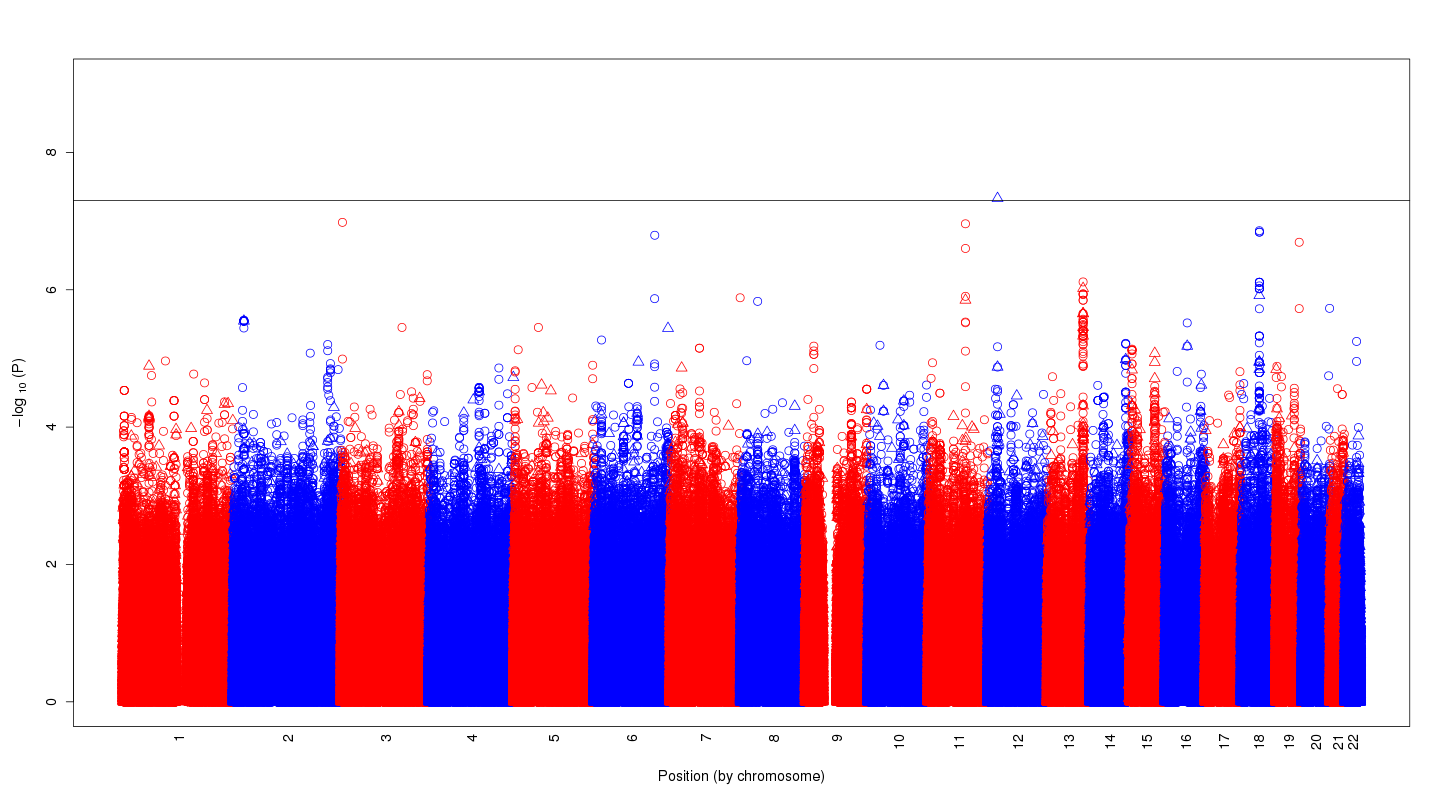

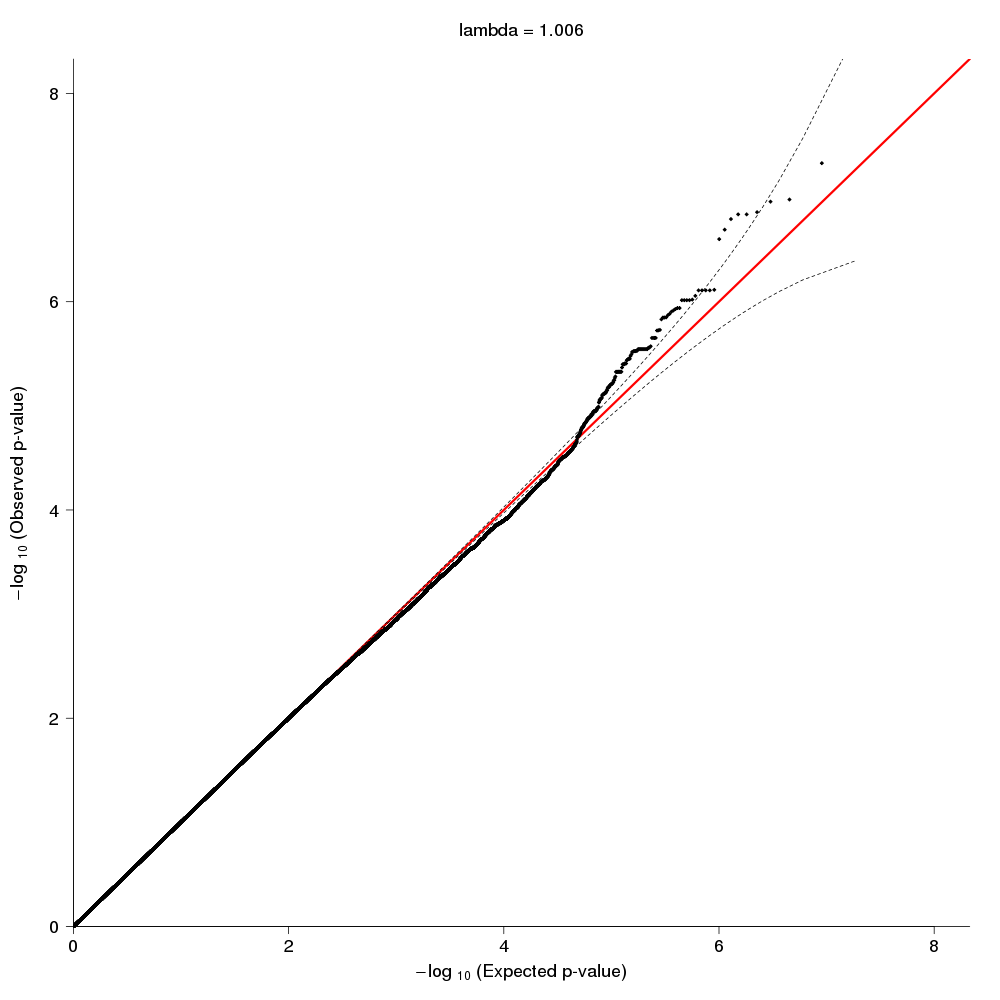

In [1]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/minnesota_twins.ea.1000G_p3.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.plots.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/minnesota_twins.ea.1000G_p3.CAT_FTND~1df.add.out.maf_gt_0.01_eur+minnesota_twins.RSQ.plots.snps+indels.qq.png")  

# Upload to S3

In [ ]:
# EC2
cd /home/ec2-user/jmarks/nicotine/gwas/minnesota_twins/association_tests/001/ea/final

aws s3 sync . s3://rti-nd/Minnesota/FTND_1df_1000G_p3/20180816/results/ --quiet &

# sandbox

In [28]:
import gzip,sys
BASE_DIR = "/home/ec2-user/jmarks/nicotine/spit_science/"
AFR = "AFR_final_ftnd.summary.gz"
AMR = "AMR_final_ftnd.summary.gz"
EAS = "EAS_final_ftnd.summary.gz"
EUR = "EUR_final_ftnd.summary.gz"
SAS = "SAS_final_ftnd.summary.gz"

# data_list = [AFR,AMR,EAS,EUR,SAS]
# ancestry_list = ['aa','amr','eas','ea','sas']
data_list = [AFR]
ancestry_list = ['aa']

for data, ancestry in zip(data_list, ancestry_list):
    inF = gzip.open(BASE_DIR + "original_results/" + data)
    # each time this is called, the next line will be returned.
    header = inF.readline().split()
    # split returns a list of words (headers)
    chrIndex = header.index("CHR") # returns 0 because CHROM is first header
    snp_index = header.index("SNP") # of form rsID:position:A1:A2
    pos_index = header.index("BP")
    a2_index = header.index("A1") + 1
    header.insert(a2_index, "A2")
    header.insert(0, "Marker")
    lastChr = ''
    line = inF.readline() 
    processed_list = []
    while(line): # while we are not at the end of the file
        split_line = line.split()
        current_chr = split_line[chrIndex]
        a2 = split_line[snp_index].split(":")[-1] # get the A2 allele
        split_line.insert(a2_index, a2)

        # if the new line is not the same chromosome as the last one processed enter loop
        # note it will enter this loop right from the gitgo because lastChr= '' by default
        if(current_chr != lastChr): 
            proc_message = "Processing {}: Chr{}".format(ancestry, current_chr)
            print(proc_message)
            # keep track of which chromosomes have been processed
            processed_list.append(current_chr)
            times_processed = processed_list.count(current_chr)
            lastChr = current_chr # new last chromosome now

            # construct outfile name
            fname = 'sfs.' + ancestry + '.1000G.chr' + split_line[chrIndex] + '.' + 'CAT_FTND~1df_add.out.txt'
            out_dir = "processed_results/{}/processing/chr{}/".format(ancestry, split_line[chrIndex])
            outF = file(BASE_DIR + out_dir + fname, 'a')

            # if the current chromosome has not been seen before then write a header to a new file
            if times_processed == 1:
                # write to a new file based on the new chr we are processing
                # also add the column Marker to the column header
                outF.write(header + "\n")
        # creating the Markername = CHR:POSITION in first field
        out_line = "{}:{}\t{}\n".format(split_line[chrIndex], split_line[pos_index], "\t".join(split_line))
        outF.write(out_line)
        #outF.write(split_line[chrIndex] + ":" + split_line[pos_index] + "\t" + "\t".join(split_line) + "\n")
        line = inF.readline() # read the next line


['CHR', 'SNP', 'BP', 'A1', 'A2', 'TEST', 'NMISS', 'BETA', 'SE', 'L95', 'U95', 'STAT', 'P']
['1', '1:10177:A:AC', '10177', 'A', 'ADD', '83', '0.01338', '0.05366', '-0.09179', '0.1185', '0.2493', '0.8038']
AC


In [1]:
help(dir)


Help on built-in function dir in module builtins:

dir(...)
    dir([object]) -> list of strings
    
    If called without an argument, return the names in the current scope.
    Else, return an alphabetized list of names comprising (some of) the attributes
    of the given object, and of attributes reachable from it.
    If the object supplies a method named __dir__, it will be used; otherwise
    the default dir() logic is used and returns:
      for a module object: the module's attributes.
      for a class object:  its attributes, and recursively the attributes
        of its bases.
      for any other object: its attributes, its class's attributes, and
        recursively the attributes of its class's base classes.

